In [1]:
# -*- coding: utf-8 -*-
"""
@File  : resnet.py
@author: FxDr
@Time  : 2023/12/27 20:50
@Description:
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


In [3]:
# -*- coding: utf-8 -*-
"""
@File  : train.py
@author: FxDr
@Time  : 2023/12/27 20:50
@Description: Training script with visualization and evaluation metrics
"""

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from torch.nn import DataParallel
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter



# 设置设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0
start_epoch = 0

# 数据预处理
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(
    root='/kaggle/input/cifar10-python', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True, num_workers=4)

validation_dataset = torchvision.datasets.CIFAR10(
    root='/kaggle/input/cifar10-python', train=False, download=True, transform=transform_test)
validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=256, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 构建模型
print('==> Building model..')
net = ResNet18()

# 使用DataParallel在多GPU上运行
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = DataParallel(net)

net = net.to(device)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 定义学习率调整策略
scheduler = MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)

# TensorBoard可视化
writer = SummaryWriter()
net

==> Building model..


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [5]:
# 训练循环
for epoch in range(start_epoch, start_epoch + 200):
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_accuracy = 100. * correct / total

    # 验证模型
    net.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validation_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_accuracy = 100. * correct / total

    print("--> Epoch Number : {}".format(epoch + 1),
          " | Training Loss : {}".format(round(train_loss / (batch_idx + 1), 4)),
          " | Validation Loss : {}".format(round(val_loss / (batch_idx + 1), 4)),
          " | Training Accuracy : {}%".format(round(train_accuracy, 2)),
          " | Validation Accuracy : {}%".format(round(val_accuracy, 2)))

    # 写入TensorBoard
    writer.add_scalar('Loss/train', train_loss / (batch_idx + 1), epoch + 1)
    writer.add_scalar('Loss/validation', val_loss / (batch_idx + 1), epoch + 1)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch + 1)
    writer.add_scalar('Accuracy/validation', val_accuracy, epoch + 1)

    # 保存模型
    if val_accuracy > best_acc:
        print('Saving model..')
        state = {
            'net': net.state_dict(),
            'acc': val_accuracy,
            'epoch': epoch,
        }
        torch.save(state, 'best_model.pth')
        best_acc = val_accuracy

    # 调整学习率
    scheduler.step()

writer.close()  # 关闭TensorBoard写入

--> Epoch Number : 1  | Training Loss : 10.6334  | Validation Loss : 1.7913  | Training Accuracy : 25.82%  | Validation Accuracy : 34.05%
Saving model..
--> Epoch Number : 2  | Training Loss : 7.4969  | Validation Loss : 1.5439  | Training Accuracy : 43.31%  | Validation Accuracy : 44.96%
Saving model..
--> Epoch Number : 3  | Training Loss : 6.2627  | Validation Loss : 1.2178  | Training Accuracy : 53.48%  | Validation Accuracy : 55.57%
Saving model..
--> Epoch Number : 4  | Training Loss : 5.2999  | Validation Loss : 1.0591  | Training Accuracy : 61.1%  | Validation Accuracy : 62.91%
Saving model..
--> Epoch Number : 5  | Training Loss : 4.6426  | Validation Loss : 0.9162  | Training Accuracy : 66.18%  | Validation Accuracy : 67.11%
Saving model..
--> Epoch Number : 6  | Training Loss : 4.1645  | Validation Loss : 0.9268  | Training Accuracy : 69.79%  | Validation Accuracy : 69.32%
Saving model..
--> Epoch Number : 7  | Training Loss : 3.7924  | Validation Loss : 0.8526  | Training A

In [16]:
!kill 11341

/bin/bash: line 1: kill: (11341) - No such process


In [17]:
%reload_ext tensorboard
%tensorboard --logdir=runs


Reusing TensorBoard on port 6006 (pid 11377), started 0:00:59 ago. (Use '!kill 11377' to kill it.)

In [18]:
!zip -r runs.zip runs


  adding: runs/ (stored 0%)
  adding: runs/Dec27_13-38-19_af626cc9500d/ (stored 0%)
  adding: runs/Dec27_13-38-19_af626cc9500d/events.out.tfevents.1703684299.af626cc9500d.42.0 (deflated 71%)


In [19]:
# 加载最好的模型并进行测试
print("Loading the best model for testing..")
best_model = ResNet18()
best_model = best_model.to(device)
best_model.load_state_dict(torch.load('best_model.pth')['net'])
best_model.eval()

test_loss = 0
correct = 0
total = 0

all_preds = []
all_targets = []

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(validation_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_accuracy = 100. * correct / total
print('Test Accuracy: {:.2f}%'.format(test_accuracy))

Loading the best model for testing..
Test Accuracy: 95.08%


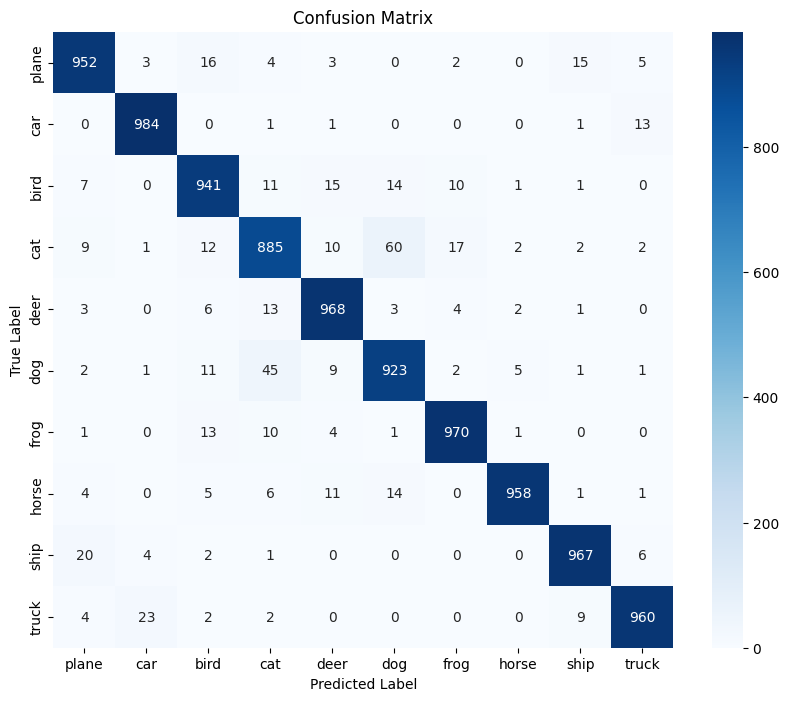

Training finished.


In [20]:
# 计算混淆矩阵
cm = confusion_matrix(all_targets, all_preds)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Training finished.")